## Analysis of factors affecting the results of European football matches season 2006 -2018

@author: astonle.68@gmail.com (Phone number: +84 987960087)

### 1. Exploring Data:


In [ ]:
Data Source:
https://www.kaggle.com/hugomathien/soccer?select=database.sqlite

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import time 
from datetime import datetime
from ast import literal_eval
from scipy.stats import shapiro
from statistics import multimode
from statistics import mode
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

In [4]:
conn = sqlite3.connect("path\database.sqlite" )
tables = pd.read_sql("""SELECT *FROM sqlite_master WHERE type='table';""", conn)
df_Country = pd.read_sql("""SELECT *FROM Country;""", conn)
df_League = pd.read_sql("""SELECT *FROM League;""", conn)
df_Match = pd.read_sql("""SELECT *FROM Match;""", conn)
df_pAtt = pd.read_sql("""SELECT *FROM Player_Attributes;""", conn)
df_Player = pd.read_sql("""SELECT *FROM Player;""", conn)
df_Team_Attributes = pd.read_sql("""SELECT *FROM Team_Attributes;""", conn)
df_Team = pd.read_sql("""SELECT *FROM Team;""", conn)

The collected data consists of 7 tables with the following characteristics:

- df_Country contains the names of 11 countries participating;
- df_League contains the names of the 11 leagues;
- df_Match contains match information including the players' coordinates on the pitch and their ids, soccer betting stats. The table has a total of 25979 matches.
- df_pAtt contains attributes (38 attributes) for a total of 11060 player data input.
- df_Player contains player names corresponding to the ids in the above tables, player's weight and height.;
- df_Team contains id and team name (299 teams).
- df_Team_Attributes contains common attributes of the team (21 attributes);

In [4]:
### Check null in 7 tables:
print(df_Country.isna().sum())
print("------"*3)
print(df_League.isna().sum())
print("------"*3)
print(df_Match.isna().sum())
print("------"*3)
print(df_pAtt.isna().sum())
print("------"*3)
print(df_Player.isna().sum())
print("------"*3)
print(df_Team_Attributes.isna().sum())
print("------"*3)
print(df_Team.isna().sum())

id      0
name    0
dtype: int64
------------------
id            0
country_id    0
name          0
dtype: int64
------------------
id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64
------------------
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility        

### 2. Handling of Tables with missing data:

#### 2.1 Table df_Player

In [7]:
df_Player = df_Player.drop('id',axis = 1)  
for i in range(0, 11060):                 
    df_Player.iloc[i,3]  = df_Player.iloc[i,3].replace(df_Player.iloc[i,3], df_Player.iloc[i,3][:4]) 
### Rounding height, weight and in pounds to kilograms:
df_Player = df_Player.assign(height = [round(df_Player.iloc[i,4])*1 for i in range(0, 11060)])  
df_Player = df_Player.assign(weight = [round(df_Player.iloc[i,5])*0.45 for i in range(0, 11060)]) 

In [8]:
### Remove special characters in the column player_name trong df_Player:
import string
def spec_str(row):
    empty_str = ""
    for i in row:
        if i not in string.punctuation and not i.isdigit():
            empty_str += i
    return empty_str

df_Player.loc[:,'player_name'] = df_Player.loc[:,'player_name'].apply(spec_str) 

In [9]:
#### Create BMI columns to df_Player:
def get_bmi(row):
    bmi = row['weight'] / (row['height'])**2
    return round(bmi * 10000) # do 'height' đang ở cm
df_Player['BMI'] = df_Player.apply(get_bmi, axis = 1)   

#### 2.2 Table df_Team

In [11]:
# Since it is possible to use the column 'team_api_id' 'to join the tables together, the column' team_fifa_api_id 'has a null in this column.
df_Team = df_Team.drop('team_fifa_api_id', axis = 1)

#### 2.3 Table df_Team_Attributes

In [13]:
## TABLE TEAM_ATTRIBUTES
print('Check describe df')
print(df_Team_Attributes.describe())
print('-----'*3)
print('Check null df')
print(df_Team_Attributes.isnull().sum())
print('-----'*3)
print('Check duplicated df')
print(df_Team_Attributes.duplicated().sum())
print('-----'*3)
print('Check type df')
print(df_Team_Attributes.dtypes)

Check describe df
                id  team_fifa_api_id    team_api_id  buildUpPlaySpeed  \
count  1458.000000       1458.000000    1458.000000       1458.000000   
mean    729.500000      17706.982167    9995.727023         52.462277   
std     421.032659      39179.857739   13264.869900         11.545869   
min       1.000000          1.000000    1601.000000         20.000000   
25%     365.250000        110.000000    8457.750000         45.000000   
50%     729.500000        485.000000    8674.000000         52.000000   
75%    1093.750000       1900.000000    9904.000000         62.000000   
max    1458.000000     112513.000000  274581.000000         80.000000   

       buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
count            489.000000         1458.000000            1458.000000   
mean              48.607362           48.490398              52.165295   
std                9.678290           10.896101              10.360793   
min               24.000000 

In [14]:
## REFORM DATE IN DF:  
from datetime import datetime
for i in range(0, 1458):
    df_Team_Attributes.iloc[i, 3] = datetime.strptime(df_Team_Attributes.iloc[i, 3], '%Y-%m-%d %H:%M:%S')

for i in range(0, 1458):
    df_Team_Attributes.iloc[i, 3] = datetime.strftime(df_Team_Attributes.iloc[i, 3], '%Y-%m-%d')
# DROP ID
df_Team_Attributes= df_Team_Attributes.drop('id', axis = 1)

In [15]:
# Doing statistics feature keys 'buildUpPlayDribblingClass' for 'Little'
check_null = df_Team_Attributes.loc[df_Team_Attributes["buildUpPlayDribblingClass"] == "Little"]        
lst = check_null['buildUpPlayDribbling'].dropna().to_list()

# Using the Gaussion distribution to choose the variable representing the 'buildUpPlayDribblingClass' attribute:
from scipy.stats import shapiro
def get_num(lst):
    if len(lst) < 3:
        return round(np.mean(lst),2)
    else:
        stat, p = shapiro(lst)
        alpha = 0.05
        if p > alpha:
            return round(np.mean(lst),2)
        elif p <= alpha:
            return round(np.median(lst),2)
get_num(lst)   

32.0

In [16]:
df_Team_Attributes[['buildUpPlayDribbling']] = df_Team_Attributes[['buildUpPlayDribbling']].fillna(value=32)

In [17]:
## Remove quantitative feature column, hold only qualitative feature column (9 columns) 
cols = list(df_Team_Attributes.columns)
print(cols)
df_Team_Attributes = df_Team_Attributes.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 
                                                'chanceCreationPassingClass', 'chanceCreationCrossingClass', 'chanceCreationShootingClass',
                                                'defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass'], axis = 1)

#...ALTERNATING 3 QUALITATIVE COLUMN WITHOUT ANY REQUIRED ARE: 'buildUpPlayPositioningClass', 'chanceCreationPositioningClass' and
# 'defenceDefenderLineClass' with 2 distinct values in each column

['team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayDribblingClass', 'buildUpPlayPassing', 'buildUpPlayPassingClass', 'buildUpPlayPositioningClass', 'chanceCreationPassing', 'chanceCreationPassingClass', 'chanceCreationCrossing', 'chanceCreationCrossingClass', 'chanceCreationShooting', 'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressure', 'defencePressureClass', 'defenceAggression', 'defenceAggressionClass', 'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass']


#### 2.4 Table df_pAtt

In [3]:
print("Null columns: \n{}".format(df_pAtt.isnull().sum()))

df_pAtt = df_pAtt.drop('id', axis = 1)

print("Null columns: \n{}".format(df_pAtt.isnull().sum()))

Null columns: 
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
stand

In [4]:
#%% CHECK NULL 'attacking_work_rate'(qualitative)

df_nan = df_pAtt.loc[df_pAtt['attacking_work_rate'].isnull()] # 3230 rows corresponding to 2394 missing id 
df_nan_group = df_nan.groupby('player_api_id').agg(lambda col: col.tolist()).reset_index() # 540 id (grouped) null
df_nan_group2 = df_nan.groupby(['player_api_id']).mean().reset_index() # 540 ID 

df_replaceDATE = df_pAtt[df_pAtt['attacking_work_rate'].notnull()] 

list_replace = []
for i in df_replaceDATE['player_api_id'].values.tolist(): 
    for j in df_nan['player_api_id'].values.tolist():
        if i == j:
            list_replace.append(i)
from collections import Counter
lst_groupid = Counter(list_replace)
lst_groupid2 = list(dict.fromkeys(list_replace)) 

## No replace value => delete 2394 rows
df_pAtt = df_pAtt[~df_pAtt['attacking_work_rate'].isnull()]  

#%% CHECK NULL 'defensive_work_rate' column(qualitative)
df_nan = df_pAtt.loc[df_pAtt['defensive_work_rate'].isnull()] # zero null id

#%% CHECK NULL 'volleys' column
df_nan = df_pAtt.loc[df_pAtt['volleys'].isnull()]

df_analyst = df_nan[['player_api_id', 'date', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle']]
# Because of ['curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle'] columns are null in the same rows
# (row df_nan = row df_analyst)

df_analyst_gr = df_pAtt.groupby('player_api_id').agg(lambda col: col.tolist()).reset_index() # 110 distinct ids are null


df_replace =  df_pAtt.loc[df_pAtt['volleys'].notnull()] # 180354
df_replace_gr = df_replace.groupby('player_api_id').agg(lambda col: col.tolist()).reset_index() # 10410 id (grouped)


list_replace = []
for i in df_replace['player_api_id'].values.tolist():
    for j in df_analyst['player_api_id'].values.tolist():
        if i == j:
            list_replace.append(i)
## LIST is EMPTY => CANNOT REPLACE, CANNOT CONTACT OTHER TABLES => REMOVE
# df_pAtt reduced from 180748 to 180354 (rows)

df_pAtt = df_pAtt[~df_pAtt['volleys'].isnull()]

In [6]:
# Check the number of player IDs lost if deleting special values in 'attacking_work_rate' column:
check = df_pAtt['attacking_work_rate'].value_counts()

df_analyst1 = df_pAtt.loc[df_pAtt['attacking_work_rate'].isin(['None', 'norm', 'y', 'le', 'stoc'])]
df_analyst2 = df_analyst1.groupby('attacking_work_rate').mean()
# Player lost attributes:
df_sum = df_analyst1['player_api_id'].value_counts() # 504 id for 3892 records
print(df_sum)
print('Record number: {}'.format(df_analyst1['player_api_id']))

79264     35
35442     26
37468     25
193866    24
79262     24
          ..
13329      1
41175      1
37491      1
210428     1
69258      1
Name: player_api_id, Length: 504, dtype: int64
Record number: 675       194479
676       194479
677       194479
678       194479
679       194479
           ...  
183732     39494
183733     39494
183734     39494
183735     39494
183736     39494
Name: player_api_id, Length: 3892, dtype: int64


In [7]:
# Check the number of player IDs lost if deleting special values in 'defensive_work_rate' columns:
check = df_pAtt['defensive_work_rate'].value_counts()

df_analyst3 = df_pAtt.loc[df_pAtt['defensive_work_rate'].isin(['_0', 'o', '1', 'ormal', '2', '3', '5', '7', '0', '6', 
                                                               '9', '4', 'es', 'ean', 'tocky', '8'])] 

df_analyst4 = df_analyst3.groupby('defensive_work_rate').mean()
# Số cầu thủ bị mất thuộc tính:    
df_sum = df_analyst3['player_api_id'].value_counts() # 504 id for 3892 records
print(df_sum)
print('Record number: {}'.format(df_analyst1['player_api_id']))

42116     38
474672    29
179866    26
35442     26
37468     25
          ..
210692     2
422281     1
33804      1
37512      1
69258      1
Name: player_api_id, Length: 504, dtype: int64
Record number: 675       194479
676       194479
677       194479
678       194479
679       194479
           ...  
183732     39494
183733     39494
183734     39494
183735     39494
183736     39494
Name: player_api_id, Length: 3892, dtype: int64


In [8]:
# The total id with 2 attributes columns 'attacking_work_rate' and 'defensive_work_rate' at the same time has special values:

df_analyst = df_pAtt.loc[df_pAtt['attacking_work_rate'].isin(['None', 'norm', 'y', 'le', 'stoc'])]

df_analyst2 = df_analyst.loc[df_analyst['defensive_work_rate'].isin(['_0', 'o', '1', 'ormal', '2', '3', '5', '7', '0', '6', '9', '4', 'es', 'ean', 'tocky', '8'])]

df_analyst2['player_api_id'].value_counts()#  504 ids for 3734 records
print(df_analyst2['player_api_id'])

675       194479
676       194479
677       194479
678       194479
679       194479
           ...  
183719     39494
183720     39494
183721     39494
183722     39494
183723     39494
Name: player_api_id, Length: 3734, dtype: int64


In [9]:
# ==> only retains rows with 1 of these 3 corresponding values for 2 columns
### (reduced from 180354 to 176161 row)
df_pAtt = df_pAtt.loc[(df_pAtt['attacking_work_rate'].isin(['medium','high','low'])\
                          & df_pAtt['defensive_work_rate'].isin(['medium','high','low']))]

In [10]:
## REFORM DATE IN DF:      
df_pAtt.date = df_pAtt.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_pAtt.date = df_pAtt.date.apply(lambda x:datetime.strftime(x, '%Y-%m-%d'))  

#### 2.5 Table df_Match

In [20]:
print(list(df_Match.columns))

['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

In [22]:
print(df_Match['goal'].value_counts().reset_index())  

                                                   index  goal
0                                               <goal />   993
1      <goal><value><comment>n</comment><stats><goals...     1
2      <goal><value><comment>n</comment><stats><goals...     1
3      <goal><value><comment>n</comment><stats><goals...     1
4      <goal><value><comment>n</comment><stats><goals...     1
...                                                  ...   ...
13220  <goal><value><comment>n</comment><stats><goals...     1
13221  <goal><value><comment>n</comment><stats><goals...     1
13222  <goal><value><comment>n</comment><stats><goals...     1
13223  <goal><value><comment>p</comment><stats><penal...     1
13224  <goal><value><comment>n</comment><stats><goals...     1

[13225 rows x 2 columns]


- Remove columns related to the football gamble and another meaningless columns: 'goal, shoton, shotoff, foulcommit, card, cross, corner, possession':

In [23]:
df_Match = df_Match.drop(df_Match.columns[[i for i in range(77, 115)]], axis = 1)
df_Match = df_Match.drop('id', axis = 1) 

#### How to create team formation column of each team in 1 Match:
In fact, the team formation will be based on y coordinates, not x because x is fixed by default). So the information about the x and y positions of each player in the matches will be summarized in one column as follows: with the last row being the goalkeeper position, midfielders and strikers) are arranged randomly because the data source does not provide the position names of each player in a match.

In [24]:
corr_HomeY = df_Match[df_Match.columns[32:43]].to_numpy().tolist()
corr_AwayY = df_Match[df_Match.columns[43:54]].to_numpy().tolist()

df_Match["Home_Y"] = pd.Series(corr_HomeY)
df_Match["Away_Y"] = pd.Series(corr_AwayY)

# Home team formation:
from collections import Counter
def get_lst(row):
    lst = []
    for i in sorted(row["Home_Y"], reverse = True):
        if np.isnan(i).any():
            lst = None
            break
        else:
            lst.append(i)
    d = dict(Counter(lst))        
    keys = []
    for j in d:
        if j == []:
            keys = np.Nan
        else:
            keys.append(j)
    return [d[x] for x in keys]
       
df_Match["Home_Formation"] = df_Match.apply(get_lst, axis = 1) 

df_Match['Home_Formation'] = df_Match['Home_Formation'].astype(str)

df_Match['Home_Formation'].replace({"[]": np.nan}, inplace=True)


### Away team formation:

from collections import Counter
def get_lst(row):
    lst = []
    for i in sorted(row["Away_Y"], reverse = True):
        if np.isnan(i).any():
            lst = None
            break
        else:
            lst.append(i)
    d = dict(Counter(lst))        
    keys = []
    for j in d:
        if j == []:
            keys = np.Nan
        else:
            keys.append(j)
    return [d[x] for x in keys]
       
df_Match["Away_Formation"] = df_Match.apply(get_lst, axis = 1) 

df_Match['Away_Formation'] = df_Match['Away_Formation'].astype(str)
df_Match['Away_Formation'].replace({"[]": None}, inplace=True)

## Delete coordinates of players
check_null = df_Match.isnull().sum().reset_index() 

df_Match.drop(df_Match.columns[[i for i in range(10, 54)]], axis = 1, inplace = True)
df_Match.drop(df_Match.columns[[i for i in range(32, 34)]], axis = 1, inplace = True)

In [25]:
# ADD FINAL RESULTS COLUMN:
def get_result(row):
    if row["home_team_goal"]-row["away_team_goal"]>0:
        return 'win'
    elif row["home_team_goal"]-row["away_team_goal"]==0:
        return 'due'
    else:
        return 'lose'

def get_result2(row):
    if row["home_team_goal"]-row["away_team_goal"]>0:
        return 'lose'
    elif row["home_team_goal"]-row["away_team_goal"]==0:
        return 'due'
    else:
        return 'win'
    
def get_home_point(row):
        if row["home_match_result"]=='win': 
            return 3 
        elif row["home_match_result"]=='due': 
            return 2 
        else: 
            return 1
        
def get_away_point(row):
        if row["home_match_result"]=='win': 
            return 1 
        elif row["home_match_result"]=='due': 
            return 2 
        else: 
            return 3
        
df_Match["home_match_result"] = df_Match.apply(get_result, axis=1)
df_Match["away_match_result"] = df_Match.apply(get_result2, axis=1)

df_Match["home_point"] = df_Match.apply(get_home_point, axis=1)
df_Match["away_point"] = df_Match.apply(get_away_point, axis=1)

#### How to handle a missing squad:
  Processing Null's data based on the frequency of the most used formation of the two teams regardless of the formation correlation relationship between the two teams (specifically, excluding the case of the opposing team. If you use it, the other team will choose the appropriate lineup. Do not consider this case because both teams are NULL at the same time in 1 match_api_id)
This method of processing data that is Null also solves the case of two teams fighting each other but has NOT recorded the squad data before, now I will use the most used lineup in df_Match to fill the blank.

In [26]:
mode1 = df_Match['Home_Formation'].mode()[0]
mode2 = df_Match['Away_Formation'].mode()[0]

df_Match['Home_Formation'] = df_Match.groupby('home_team_api_id')['Home_Formation'].apply(lambda x: \
        x.fillna(x.value_counts().idxmax() if x.value_counts().max() >=1 else mode1 , inplace = False)) 

df_Match['Away_Formation'] = df_Match.groupby('away_team_api_id')['Away_Formation'].apply(\
          lambda x: x.fillna(x.value_counts().idxmax() if x.value_counts().max() >=1 else mode2 , inplace = False)) 

## FILL NAN FOR HOME_PLAYER_ID (5.98% NULL)

cols = list(df_Match.columns)

lst_HomeY = df_Match[df_Match.columns[10:21]].to_numpy().tolist()
lst_AwayY = df_Match[df_Match.columns[21:32]].to_numpy().tolist()


df_Match["Home_list_Player"] = pd.Series(lst_HomeY)
df_Match["Away_list_Player"] = pd.Series(lst_AwayY)

import math
def get_nan(row):
    lst = []
    for i in row['Home_list_Player']:
        if np.isnan(i).any():
            lst = np.NaN
            break
        else:
            lst.append(math.floor(i))
    return lst

df_Match["Home_list_Player"] = df_Match.apply(get_nan, axis = 1)   

def get_nan(row):
    lst = []
    for i in row['Away_list_Player']:
        if np.isnan(i).any():
            lst = np.NaN
            break
        else:
            lst.append(math.floor(i))
    return lst

df_Match["Away_list_Player"] = df_Match.apply(get_nan, axis = 1)  

In [27]:
## Check coding:
z = df_Match.groupby('home_team_api_id')['Home_Formation']
print(z.describe())

                 count unique              top freq
home_team_api_id                                   
1601               120      4  [1, 3, 2, 4, 1]  113
1773                45      6     [3, 3, 4, 1]   12
1957               120      5  [1, 3, 2, 4, 1]  111
2033                75      5  [1, 3, 2, 4, 1]   43
2182               120      5  [1, 3, 2, 4, 1]  111
...                ...    ...              ...  ...
158085              49      3     [3, 3, 4, 1]   29
177361              15      2  [1, 3, 2, 4, 1]   14
188163              17      2     [3, 3, 4, 1]   14
208931              19      5  [1, 1, 4, 4, 1]    9
274581              30      6  [1, 3, 2, 4, 1]   12

[299 rows x 4 columns]


In [28]:
df_Match.to_csv(r'E:/ANALYST FOOTBALL/table_Match.csv', index = False) 
## SAVE FILE FIRST THEN LOADING AGAIN WILL NOT HAVE A CODE RUN ERROR BELOW:

In [29]:
df_Match = pd.read_csv('E:/ANALYST FOOTBALL/table_Match.csv')

# FILL FORM ON THE LIST OF MOST PLAYERS:
## Home Team:
df_Match['Home_list_Player'] = df_Match.groupby('home_team_api_id')['Home_list_Player'].apply(lambda x: \
            x.fillna(x.value_counts().idxmax() if x.value_counts().max() >= 1 else np.NaN, inplace = False))
    
## Away Team:
df_Match['Away_list_Player'] = df_Match.groupby('away_team_api_id')['Away_list_Player'].apply(lambda x: \
            x.fillna(x.value_counts().idxmax() if x.value_counts().max() >= 1 else np.NaN, inplace = False))   

In [30]:
### CHECKING:
df_Analyst1 = df_Match[['date', 'home_match_result','home_team_api_id','Home_list_Player', 'Home_Formation']] # home list null and not null

df_Analyst2 = df_Match[['Home_list_Player', 'home_team_api_id']].groupby(['Home_list_Player']).mean().reset_index() # 22113# home list not null

df_Analyst3 = df_Match[['date', 'home_match_result','away_team_api_id','Away_list_Player', 'Away_Formation']]
df_Analyst4 = df_Match[['Away_list_Player', 'away_team_api_id']].groupby(['Away_list_Player']).mean().reset_index()

## The home team statistics with list_player are still null:
df_analyst = df_Analyst1.loc[df_Analyst1['Home_list_Player'].isnull()]
group_home_null = df_analyst['home_team_api_id'].value_counts() 

## The away team statistics with list_player are still null:

df_analyst_away = df_Analyst3.loc[df_Analyst3['Away_list_Player'].isnull()]
group_away_null = df_analyst_away['away_team_api_id'].value_counts() 

In [31]:
print("Home team statistics have null player list: \n{}.".format(group_home_null)) 
print("Away team statistics have null player list: \n{}.".format(group_away_null))

Home team statistics have null player list: 
8322     45
8031     45
8244     30
8242     30
4049     17
6601     17
9996     17
7947     17
10213    15
7992     15
Name: home_team_api_id, dtype: int64.
Away team statistics have null player list: 
8322     45
8031     45
8244     30
8242     30
4049     17
6601     17
9996     17
7947     17
10213    15
7992     15
Name: away_team_api_id, dtype: int64.


- Fill null for these 10 Ids. Fill null is based on the principle of: taking the highest frequency of appearances of players in each column, if that column is NULL, it will be replaced with the highest frequency after the previous occurrence.

In [32]:
check_freq = df_Match.loc[df_Match['home_team_api_id'] == 7992]  ## change team_id here to see frequency of player ids and do FILL NAN
print(check_freq[['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 
         'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11']])

       home_player_1  home_player_2  home_player_3  home_player_4  \
17656            NaN            NaN            NaN            NaN   
17664        22125.0        97463.0        45285.0       149959.0   
17680            NaN            NaN            NaN            NaN   
17696            NaN            NaN            NaN            NaN   
17704            NaN            NaN            NaN            NaN   
17720        22125.0        97463.0        45285.0       149959.0   
17736            NaN            NaN            NaN            NaN   
17744            NaN        97463.0       149959.0        45285.0   
17760            NaN        97463.0       149959.0        45285.0   
17776            NaN       163665.0        45285.0       149959.0   
17800            NaN       163665.0        45285.0       149959.0   
17816            NaN       163665.0       149959.0        45285.0   
17840            NaN            NaN            NaN            NaN   
17856            NaN            Na

- Due to the complex nature of creating formation teams and the current number of nulls is not too much, there will be a manual null fill here.

In [33]:

df_Match.Home_list_Player[df_Match.home_team_api_id == 4049] = '[32990, 148292, 37976, 148289, 94184, 37085, 37972, 38410, 9144, 17703, 39157]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 6601] = '[5044, 5686, 26558, 45893, 101042, 26716, 26657, 104005, 26568, 104010, 5687]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 7947] = '[39153, 39575, 46459, 26606, 67896, 15662, 178291, 15913, 45413, 149367, 116788]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 7992] = '[22125, 97463, 45285, 149959, 40951, 163665, 45371, 25390, 22134, 150318, 38241]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 8031] = '[13390, 121643, 78537, 13504, 13329, 155611, 13490, 79241, 116872, 68836, 147980]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 8322] = '[68740, 184618, 93261, 40976, 13329, 150809, 105526, 33804, 12307, 13483, 38604]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 8244] = '[36641, 178702, 13425, 117556, 69227, 13349, 69223, 69346, 69238, 36640, 30272]'

df_Match.Home_list_Player[df_Match.home_team_api_id == 10213] = '[40610, 40933, 39627, 150018, 97326, 150024, 74633, 96854, 96846, 22139, 40187]'

<ipython-input-33-70d98e5ba066>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Match.Home_list_Player[df_Match.home_team_api_id == 4049] = '[32990, 148292, 37976, 148289, 94184, 37085, 37972, 38410, 9144, 17703, 39157]'
<ipython-input-33-70d98e5ba066>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Match.Home_list_Player[df_Match.home_team_api_id == 6601] = '[5044, 5686, 26558, 45893, 101042, 26716, 26657, 104005, 26568, 104010, 5687]'
<ipython-input-33-70d98e5ba066>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [34]:
df_Match.Away_list_Player[df_Match.away_team_api_id == 4049] = '[32990, 148292, 37976, 148289, 94184, 37085, 37972, 38410, 9144, 17703, 39157]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 6601] = '[5044, 5686, 26558, 45893, 101042, 26716, 26657, 104005, 26568, 104010, 5687]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 7947] = '[39153, 39575, 46459, 26606, 67896, 15662, 178291, 15913, 45413, 149367, 116788]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 7992] = '[22125, 97463, 45285, 149959, 40951, 163665, 45371, 25390, 22134, 150318, 38241]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 8031] = '[13390, 121643, 78537, 13504, 13329, 155611, 13490, 79241, 116872, 68836, 147980]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 8322] = '[68740, 184618, 93261, 40976, 13329, 150809, 105526, 33804, 12307, 13483, 38604]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 8244] = '[36641, 178702, 13425, 117556, 69227, 13349, 69223, 69346, 69238, 36640, 30272]'

df_Match.Away_list_Player[df_Match.away_team_api_id == 10213] = '[40610, 40933, 39627, 150018, 97326, 150024, 74633, 96854, 96846, 22139, 40187]'

<ipython-input-34-aee8601aa03b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Match.Away_list_Player[df_Match.away_team_api_id == 4049] = '[32990, 148292, 37976, 148289, 94184, 37085, 37972, 38410, 9144, 17703, 39157]'
<ipython-input-34-aee8601aa03b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Match.Away_list_Player[df_Match.away_team_api_id == 6601] = '[5044, 5686, 26558, 45893, 101042, 26716, 26657, 104005, 26568, 104010, 5687]'
<ipython-input-34-aee8601aa03b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [35]:
## DROP 2 teams with the number of players not enough 11 players:
df_Match = df_Match[df_Match.home_team_api_id != 8242]

df_Match = df_Match[df_Match.home_team_api_id != 9996]

df_Match = df_Match[df_Match.away_team_api_id != 8242]

df_Match = df_Match[df_Match.away_team_api_id != 9996]

In [39]:
df_Match.drop(df_Match.columns[[i for i in range(10, 32)]], axis = 1, inplace = True)

In [43]:
## CHANGE DATE FORMAT:
df_Match.date  = df_Match.date .apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_Match.date  = df_Match.date .apply(lambda x:datetime.strftime(x, '%Y-%m-%d'))   

In [45]:
# SAVE TABLE:
df_Match.to_csv(r'E:/ANALYST FOOTBALL/JUPITER FILE/table_Match.csv', index = False)

### 3. Merge Table

##### Merge df_Country, df_League and df_Match:

In [6]:
df_League.rename({"name" : "league_name"}, axis = 'columns', inplace = True)

df_League_update = pd.merge(df_League, df_Country, how = "left", left_on = "country_id", right_on = "id")[["country_id","name", "league_name"]]

df_League_update.rename({"name" : "country"}, axis = 'columns', inplace = True)


df_Match = pd.merge(df_Match, df_League_update, how = "left", left_on = "country_id", \
                            right_on = "country_id")[['country', 'league_name', 'season',\
                           'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
                           'home_team_goal', 'away_team_goal', 'Home_Formation', 'Away_Formation', 
                           'home_match_result', 'away_match_result', 'home_point', 'away_point', 'Home_list_Player', 'Away_list_Player']]

In [7]:
## CHECK the number of teams in df_Match that have attributes in df_Team_Attributes:
count_t1 = df_Match['home_team_api_id'].value_counts().reset_index()
count_t2 = df_Team_Attributes['team_api_id'].value_counts().reset_index() 
list_sum1 = count_t1['index'].to_list()
list_sum2 = count_t2['index'].to_list()

lst = [x for x in list_sum1 if x not in list_sum2]
print(lst)

[7896, 188163, 6367, 6601, 4049, 7947, 7992, 177361, 10213, 4064, 9765]


In [8]:
## REMOVE 11 TEAM WITHOUT Df_Team_Attributes in df_Match

df_Match = df_Match[~(df_Match.home_team_api_id.isin(lst))] 

df_Match = df_Match[~(df_Match.away_team_api_id.isin(lst))]

In [9]:
### Change 'Team_api_id' to 'Team_long_name' in Table df_Team_Attributes:

df_Team_Attributes = pd.merge(df_Team_Attributes, df_Team, how = "left", left_on = "team_api_id", right_on = "team_api_id")[[
        'date', 'team_long_name','buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'buildUpPlayPositioningClass', 'chanceCreationPassing', 
        'chanceCreationCrossing', 'chanceCreationShooting', 'chanceCreationPositioningClass', 'defencePressure', 
        'defenceAggression', 'defenceTeamWidth', 'defenceDefenderLineClass']]

In [10]:
### Change 'TEAM_API_ID' to Home Team Name and Away Team Name

df_Match = pd.merge(df_Match, df_Team, how = "left", left_on = 'home_team_api_id', right_on='team_api_id', suffixes= ['', '_home'])

df_Match = pd.merge(df_Match, df_Team, how = "left", left_on = 'away_team_api_id', right_on='team_api_id', suffixes= ['', '_away'])

In [11]:
df_Match = df_Match.rename(columns = {'team_long_name':'home_team_name', 'team_long_name_away':'away_team_name'})

In [13]:
df_Match.drop(['home_team_api_id', 'away_team_api_id', 'id', 'team_api_id', 'team_short_name', 'id_away', 'team_api_id_away', 
               'team_short_name_away'], axis = 1, inplace = True)

In [14]:
# Check the team name has no attributes (no names in Table df_Team_Attributes)
lst1 = df_Match['home_team_name'].to_list()
lst2 = df_Team_Attributes['team_long_name'].to_list()
print(set(lst1) - set(lst2))

set()


In [17]:
# Check 'date' column between df_Match_update vs df_Team_Attributes
print(df_Match_update.date.value_counts())
print(df_Team_Attributes.date.value_counts())

2009-04-11    56
2015-04-04    55
2013-03-30    54
2010-04-03    53
2009-09-26    52
              ..
2016-01-04     1
2010-04-21     1
2010-07-30     1
2013-02-05     1
2008-08-11     1
Name: date, Length: 1687, dtype: int64
2015-09-10    245
2011-02-22    244
2014-09-19    244
2013-09-20    242
2012-02-22    242
2010-02-22    241
Name: date, dtype: int64


#### Merge 'df_Team_Attributes' attributes into 'df_Match'
- Merge principle: due to the inconsistent date attribute data between df_Team_Attributes and df_Match. So we will get the team attribute from df_Team_Attributes into the df_Match table based on the most recent date.
- Because the number of attributes is quite large. Avoiding error or kernal restarts, attributes will be splitted to merge:

In [18]:
def get_Home_TeamAttributes(row):
    temp = df_Team_Attributes[df_Team_Attributes['team_long_name']  ==  row['home_team_name']]
    temp['date_diff'] = abs((pd.to_datetime(temp['date'])-pd.to_datetime(row['date'])).dt.days)
    temp=temp.sort_values(by='date_diff').drop_duplicates('team_long_name', keep='first')
    if len(temp)==0:
        return 0
    else:
        return temp.iloc[0][colName]
def get_Away_TeamAttributes(row):
    temp = df_Team_Attributes[df_Team_Attributes['team_long_name']  ==  row['away_team_name']]
    temp['date_diff'] = abs((pd.to_datetime(temp['date'])-pd.to_datetime(row['date'])).dt.days)
    temp=temp.sort_values(by='date_diff').drop_duplicates('team_long_name', keep='first')
    if len(temp)==0:
        return 0
    else:
        return temp.iloc[0][colName]
# List of attributes to get:
atts = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'buildUpPlayPositioningClass', 
        'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'chanceCreationPositioningClass', 
        'defencePressure', 'defenceAggression', 'defenceTeamWidth', 'defenceDefenderLineClass']
colName = ''

In [19]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)

for att in atts:
    colName = att
    print(colName)
    df_Match_update['home_'+colName] = df_Match_update.apply(get_Home_TeamAttributes, axis=1)
for att in atts:
    colName = att
    print(colName)
    df_Match_update['away_'+colName] = df_Match_update.apply(get_Away_TeamAttributes, axis=1)
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("end Time =", current_time)

start Time = 07:36:33
buildUpPlaySpeed
buildUpPlayDribbling
buildUpPlayPassing
buildUpPlayPositioningClass
chanceCreationPassing
chanceCreationCrossing
chanceCreationShooting
chanceCreationPositioningClass
defencePressure
defenceAggression
defenceTeamWidth
defenceDefenderLineClass
buildUpPlaySpeed
buildUpPlayDribbling
buildUpPlayPassing
buildUpPlayPositioningClass
chanceCreationPassing
chanceCreationCrossing
chanceCreationShooting
chanceCreationPositioningClass
defencePressure
defenceAggression
defenceTeamWidth
defenceDefenderLineClass
end Time = 08:43:26


In [26]:
print(df_pAtt.columns.tolist())
print(df_Player.columns.tolist())
print('-------'*3)
print(df_Match_update.columns.tolist())

['player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
['player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight', 'BMI']
---------------------
['country', 'league_name', 'season', 'stage', 'date', 'match_api_id', 'home_team_goal', 'away_team_goal', 'Home_Formation', 'Away_Formation', 'home_match_result', 'away_match_result', 'home_point', 'away_point', 'Home_list_Player', 'Away_list_Player', 'home_team_name', '

In [27]:
# Add 'birthday' column from df_Patt to df_Match: (do not add 'height', 'weight', 'BMI', because df_Player does not have
# update these 3 attributes by 'date' as df_pAtt):
df_pAtt = pd.merge(df_pAtt, df_Player, how = 'left', 
                  left_on = 'player_api_id', right_on = 'player_api_id')[['player_api_id', 'player_name', 'date', 
                'birthday', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 
                'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 
                'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 
                'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 
                'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 
                'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

In [28]:
df_pAtt.to_csv('E:/ANALYST FOOTBALL/JUPITER FILE/table_pAtt2.csv', index = False)    

In [29]:
# Merge attribtes of players from df_Patt into df_Match:
df_Match_update.loc[:,'Home_list_Player'] = df_Match_update.loc[:,'Home_list_Player'].apply(lambda x: literal_eval(x)) 
df_Match_update.loc[:,'Away_list_Player'] = df_Match_update.loc[:,'Away_list_Player'].apply(lambda x: literal_eval(x)) 

a1 = df_Match_update.Home_list_Player.to_list()
lsta1 = []
for i in a1:
    for j in i:
        lsta1.append(j)
a_1 = list(dict.fromkeys(lsta1))
b1 = set(df_pAtt.player_api_id.to_list())
lst1 = set(lsta1) - set(b1)

a2 = df_Match_update.Away_list_Player.to_list()
lsta2 = []
for i in a2:
    for j in i:
        lsta2.append(j)
a_2 = list(dict.fromkeys(lsta2))
b2 = set(df_pAtt.player_api_id.to_list())
lst2 = set(lsta2) - set(b2)


print('Home team player count has no attributes in df_pAtt: {}, take {}% in df_Match'.format(len(lst1), round(len(lst1)*100/len(a_1),2)))
print('Away team player count has no attributes in df_pAtt: {}, take {}% in df_Match'.format(len(lst2), round(len(lst2)*100/len(a_2),2)))

Home team player count has no attributes in df_pAtt: 955, take 9.32% in df_Match
Away team player count has no attributes in df_pAtt: 948, take 9.18% in df_Match


-  Since there are a number of home and away team players (about 9.3%) in df_Match have no attributes, it is impossible to get all the attributes in df_pAtt into df_Match. So I will get the attributes of the players from df_pAtt based on the value represented in the list of attributes into df_Match

In [31]:
# Add 'Years of birthday' column for Home Team and Away Team:

def get_birthday(row):
    temp = df_Player[df_Player['player_api_id'].isin(row['Home_list_Player'])]
    return temp['birthday'].tolist()

def get_birthday(row):
    temp = df_Player[df_Player['player_api_id'].isin(row['Away_list_Player'])]
    return temp['birthday'].tolist()

df_Match_update["Home_birthday"] = df_Match_update.apply(get_birthday, axis=1)
df_Match_update["Away_birthday"] = df_Match_update.apply(get_birthday, axis=1)

In [32]:
# Add 'Age' columns for player:
from ast import literal_eval 
df_Match_update['date'] = pd.to_datetime(df_Match_update['date'])

def get_age(row):
    age = []
    for i in row['Home_birthday']:
        age.append(row['date'].year - int(i))
    return age

def get_age(row):
    age = []
    for i in row['Away_birthday']:
        age.append(row['date'].year - int(i))
    return age

df_Match_update['Home_age'] = df_Match_update.apply(get_age, axis=1)
df_Match_update['Away_age'] = df_Match_update.apply(get_age, axis=1)

- Merge 38 attributes of Home_Team and Away_Team (76 attributes total) on df_Match. The way to get attributes by date is also based on the principle of getting df_Team_Attributes's attributes

In [34]:
def get_Home_Attributes(row):
    temp = df_pAtt[df_pAtt['player_api_id'].isin(row['Home_list_Player'])]
    temp['date_diff'] = abs((pd.to_datetime(temp['date'])-pd.to_datetime(row['date'])).dt.days)
    temp=temp.sort_values(by='date_diff').drop_duplicates('player_api_id', keep='first')
    return temp[colName].tolist()

def get_Away_Attributes(row):
    temp = df_pAtt[df_pAtt['player_api_id'].isin(row['Home_list_Player'])]
    temp['date_diff'] = abs((pd.to_datetime(temp['date'])-pd.to_datetime(row['date'])).dt.days)
    temp=temp.sort_values(by='date_diff').drop_duplicates('player_api_id', keep='first')
    return temp[colName].tolist()

# List of attributes to get:
atts = ['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
colName = ''

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)

for att in atts:
    colName = att
    print(colName)
    df_Match_update['Home_'+colName] = df_Match_update.apply(get_Home_Attributes, axis=1)   
for att in atts:
    colName = att
    print(colName)
    df_Match_update['Away_'+colName] = df_Match_update.apply(get_Away_Attributes, axis=1)
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("end Time =", current_time)

start Time = 08:47:27
overall_rating
potential
preferred_foot
attacking_work_rate
defensive_work_rate
crossing
finishing
heading_accuracy
short_passing
volleys
dribbling
curve
free_kick_accuracy
long_passing
ball_control
acceleration
sprint_speed
agility
reactions
balance
shot_power
jumping
stamina
strength
long_shots
aggression
interceptions
positioning
vision
penalties
marking
standing_tackle
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes
overall_rating
potential
preferred_foot
attacking_work_rate
defensive_work_rate
crossing
finishing
heading_accuracy
short_passing
volleys
dribbling
curve
free_kick_accuracy
long_passing
ball_control
acceleration
sprint_speed
agility
reactions
balance
shot_power
jumping
stamina
strength
long_shots
aggression
interceptions
positioning
vision
penalties
marking
standing_tackle
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes
end Time = 14:42:03


- Since the number of player attributes is insufficient for some teams, a representative value will be selected (78 attributes)

In [52]:
atts = ['Home_age', 'Away_age', 'Home_overall_rating', 'Home_potential', 'Home_preferred_foot', 'Home_attacking_work_rate', 
        'Home_defensive_work_rate', 'Home_crossing', 'Home_finishing', 'Home_heading_accuracy', 
        'Home_short_passing', 'Home_volleys', 'Home_dribbling', 'Home_curve', 'Home_free_kick_accuracy', 
        'Home_long_passing', 'Home_ball_control', 'Home_acceleration', 'Home_sprint_speed', 'Home_agility', 
        'Home_reactions', 'Home_balance', 'Home_shot_power', 'Home_jumping', 'Home_stamina', 'Home_strength', 
        'Home_long_shots', 'Home_aggression', 'Home_interceptions', 'Home_positioning', 'Home_vision', 
        'Home_penalties', 'Home_marking', 'Home_standing_tackle', 'Home_sliding_tackle', 'Home_gk_diving', 
        'Home_gk_handling', 'Home_gk_kicking', 'Home_gk_positioning', 'Home_gk_reflexes', 'Away_overall_rating', 
        'Away_potential', 'Away_preferred_foot', 'Away_attacking_work_rate', 'Away_defensive_work_rate', 
        'Away_crossing', 'Away_finishing', 'Away_heading_accuracy', 'Away_short_passing', 'Away_volleys', 
        'Away_dribbling', 'Away_curve', 'Away_free_kick_accuracy', 'Away_long_passing', 'Away_ball_control', 
        'Away_acceleration', 'Away_sprint_speed', 'Away_agility', 'Away_reactions', 'Away_balance', 
        'Away_shot_power', 'Away_jumping', 'Away_stamina', 'Away_strength', 'Away_long_shots', 'Away_aggression', 
        'Away_interceptions', 'Away_positioning', 'Away_vision', 'Away_penalties', 'Away_marking', 
        'Away_standing_tackle', 'Away_sliding_tackle', 'Away_gk_diving', 'Away_gk_handling', 
        'Away_gk_kicking', 'Away_gk_positioning', 'Away_gk_reflexes']

In [53]:
att_s = ['Home_preferred_foot', 'Home_attacking_work_rate', 'Home_defensive_work_rate', 'Away_preferred_foot',
       'Away_attacking_work_rate', 'Away_defensive_work_rate']
def get_Mode(row):
    return multimode(row[att])
for att in att_s:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x))  
    df_Match_update[att] = df_Match_update.apply(get_Mode, axis = 1)

In [56]:
def get_att1(row):
    if len(row[att+col]) < 3:
        return round(np.mean(row[att+col]),2)
    else:
        stat, p = shapiro(row[att+col])
        alpha = 0.05
        if p > alpha:
            return round(np.mean(row[att+col]),2)
        elif p <= alpha:
            return round(np.median(row[att+col]),2)
atts = ['Home_age', 'Away_age', 'Home_overall_rating', 'Home_potential', 'Home_crossing', 'Home_finishing', 'Home_heading_accuracy', 
        'Home_short_passing', 'Home_volleys', 'Home_dribbling', 'Home_curve', 'Home_free_kick_accuracy', 
        'Home_long_passing', 'Home_ball_control', 'Home_acceleration', 'Home_sprint_speed', 'Home_agility'] 
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x))  

col = ''
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 

for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_att1, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)    

Start Time = 15:00:16
Home_age
Away_age
Home_overall_rating
Home_potential
Home_crossing
Home_finishing
Home_heading_accuracy
Home_short_passing
Home_volleys
Home_dribbling
Home_curve
Home_free_kick_accuracy
Home_long_passing
Home_ball_control
Home_acceleration
Home_sprint_speed
Home_agility
End Time = 15:01:06


In [59]:
def get_att2(row):
    if len(row[att+col]) < 3:
        return round(np.mean(row[att+col]),2)
    else:
        stat, p = shapiro(row[att+col])
        alpha = 0.05
        if p > alpha:
            return round(np.mean(row[att+col]),2)
        elif p <= alpha:
            return round(np.median(row[att+col]),2)
atts = ['Home_reactions', 'Home_balance', 'Home_shot_power', 'Home_jumping', 'Home_stamina', 'Home_strength', 
        'Home_long_shots', 'Home_aggression', 'Home_interceptions', 'Home_positioning', 'Home_vision', 
        'Home_penalties', 'Home_marking', 'Home_standing_tackle', 'Home_sliding_tackle'] 
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x)) 
col = ''
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 

for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_att2, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)   

Start Time = 15:01:35
Home_reactions
Home_balance
Home_shot_power
Home_jumping
Home_stamina
Home_strength
Home_long_shots
Home_aggression
Home_interceptions
Home_positioning
Home_vision
Home_penalties
Home_marking
Home_standing_tackle
Home_sliding_tackle
End Time = 15:02:20


In [62]:
def get_att3(row):
    if len(row[att+col]) < 3:
        return round(np.mean(row[att+col]),2)
    else:
        stat, p = shapiro(row[att+col])
        alpha = 0.05
        if p > alpha:
            return round(np.mean(row[att+col]),2)
        elif p <= alpha:
            return round(np.median(row[att+col]),2)
atts = ['Away_overall_rating', 'Away_potential', 'Away_crossing', 'Away_finishing', 'Away_heading_accuracy', 'Away_short_passing', 'Away_volleys', 
        'Away_dribbling', 'Away_curve', 'Away_free_kick_accuracy']
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x)) 
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 
for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_att3, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)    


Start Time = 15:03:01
Away_overall_rating
Away_potential
Away_crossing
Away_finishing
Away_heading_accuracy
Away_short_passing
Away_volleys
Away_dribbling
Away_curve
Away_free_kick_accuracy
End Time = 15:03:30


In [64]:
def get_att4(row):
    if len(row[att+col]) < 3:
        return round(np.mean(row[att+col]),2)
    else:
        stat, p = shapiro(row[att+col])
        alpha = 0.05
        if p > alpha:
            return round(np.mean(row[att+col]),2)
        elif p <= alpha:
            return round(np.median(row[att+col]),2)        
atts = ['Away_long_passing', 'Away_ball_control', 'Away_acceleration', 'Away_sprint_speed', 'Away_agility', 'Away_reactions', 
        'Away_balance', 'Away_shot_power', 'Away_jumping', 'Away_stamina', 'Away_strength', 'Away_long_shots', 
        'Away_aggression', 'Away_interceptions'] 
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x)) 
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 
for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_att4, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)    

Start Time = 15:04:33
Away_long_passing
Away_ball_control
Away_acceleration
Away_sprint_speed
Away_agility
Away_reactions
Away_balance
Away_shot_power
Away_jumping
Away_stamina
Away_strength
Away_long_shots
Away_aggression
Away_interceptions
End Time = 15:05:20


In [67]:
def get_att5(row):
    if len(row[att+col]) < 3:
        return round(np.mean(row[att+col]),2)
    else:
        stat, p = shapiro(row[att+col])
        alpha = 0.05
        if p > alpha:
            return round(np.mean(row[att+col]),2)
        elif p <= alpha:
            return round(np.median(row[att+col]),2)
col = ''
atts = ['Away_positioning', 'Away_vision', 'Away_penalties', 'Away_marking', 'Away_standing_tackle', 'Away_sliding_tackle']     
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x)) 
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 
for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_att5, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)    

Start Time = 15:05:37
Away_positioning
Away_vision
Away_penalties
Away_marking
Away_standing_tackle
Away_sliding_tackle
End Time = 15:05:57


In [75]:
def get_max(row):
    temp = max(row[att+col])
    return temp
col = ''
atts = ['Home_gk_diving', 'Home_gk_handling', 'Home_gk_kicking', 'Home_gk_positioning', 'Home_gk_reflexes', 
'Away_gk_diving', 'Away_gk_handling', 'Away_gk_kicking', 'Away_gk_positioning', 'Away_gk_reflexes']     
for att in atts:
    df_Match_update.loc[:,att] = df_Match_update.loc[:,att].apply(lambda x: literal_eval(x)) 
       
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time) 
for att in atts:
    print(att)
    df_Match_update[att+col] = df_Match_update.apply(get_max, axis = 1)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)    

Start Time = 15:27:54
Home_gk_diving
Home_gk_handling
Home_gk_kicking
Home_gk_positioning
Home_gk_reflexes
Away_gk_diving
Away_gk_handling
Away_gk_kicking
Away_gk_positioning
Away_gk_reflexes
End Time = 15:27:59


In [77]:
## Check Outliers:
df_Match_update.describe()

,stage,match_api_id,home_team_goal,away_team_goal,home_point,away_point,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_chanceCreationPassing,...,Away_vision,Away_penalties,Away_marking,Away_standing_tackle,Away_sliding_tackle,Away_gk_diving,Away_gk_handling,Away_gk_kicking,Away_gk_positioning,Away_gk_reflexes
count,25539.000000,2.553900e+04,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,...,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000,25539.000000
mean,18.269196,1.198336e+06,1.544461,1.161909,2.171033,1.828967,52.325111,36.803085,47.878030,52.342300,...,60.950803,56.656543,55.285657,60.659244,57.838801,71.970242,68.568581,68.792866,69.641137,73.737734
std,10.421864,4.908316e+05,1.297211,1.141893,0.846578,0.846578,12.242712,9.227557,11.466758,10.789878,...,7.693963,8.180829,9.995887,10.283820,10.303967,13.331319,12.227108,10.817581,12.465239,12.948136
min,1.000000,4.831290e+05,0.000000,0.000000,1.000000,1.000000,20.000000,24.000000,20.000000,21.000000,...,35.000000,15.000000,7.000000,8.000000,10.000000,6.000000,8.000000,11.000000,8.000000,7.000000
25%,9.000000,8.299505e+05,1.000000,0.000000,1.000000,1.000000,45.000000,32.000000,39.000000,45.000000,...,55.550000,51.270000,48.180000,53.000000,49.720000,68.000000,64.000000,63.000000,65.000000,69.000000
50%,18.000000,1.216852e+06,1.000000,1.000000,2.000000,2.000000,53.000000,32.000000,48.000000,52.000000,...,60.880000,55.600000,55.000000,61.000000,57.640000,74.000000,71.000000,69.000000,72.000000,76.000000
75%,27.000000,1.709830e+06,2.000000,2.000000,3.000000,3.000000,63.000000,36.000000,55.000000,60.000000,...,66.180000,61.360000,63.000000,69.000000,67.000000,80.000000,76.000000,75.000000,77.000000,82.000000
max,38.000000,2.216672e+06,10.000000,9.000000,3.000000,3.000000,80.000000,77.000000,80.000000,80.000000,...,85.500000,87.120000,84.000000,87.000000,84.000000,94.000000,92.000000,97.000000,94.000000,96.000000


In [57]:
check_team1 = df_Match_update.groupby('home_team_name')['Home_preferred_foot'].describe().reset_index()
check_team2 = df_Match_update.groupby('away_team_name')['Away_preferred_foot'].describe().reset_index()
print(check_team1.sort_values(by=['top'], ascending=False))
print('---'*3)
print(check_team2.sort_values(by=['top'], ascending=False))

                home_team_name count unique                top freq
0         1. FC Kaiserslautern    34      1          ['right']   34
187              Polonia Bytom   146      1          ['right']  146
193                    RC Lens    57      2          ['right']   52
192  RC Deportivo de La Coruña   114      1          ['right']  114
191           RC Celta de Vigo    76      1          ['right']   76
..                         ...   ...    ...                ...  ...
93                FC St. Pauli    17      1          ['right']   17
92               FC St. Gallen   106      1          ['right']  106
283              Śląsk Wrocław   117      1          ['right']  117
40                 CD Numancia    19      3  ['right', 'left']    8
84                     FC Metz    19      4           ['left']    9

[284 rows x 5 columns]
---------
                away_team_name count unique        top freq
0         1. FC Kaiserslautern    34      1  ['right']   34
187              Polonia Bytom

In [13]:
# Remove duplicated 'preferred_foot' in df_Match:   
atts = ['Home_preferred_foot', 'Away_preferred_foot']    
col = ''    
    
def change_foot(row):
    if row[att+col] ==  '''['right', 'left']''':
        return '''['left', 'right']'''
    else:
        return row[att+col]

for att in atts:
    df_Match_update[att+col] = df_Match_update.apply(change_foot, axis = 1)

In [4]:
df_analyst = df_Match_update.drop(['country', 'league_name', 'season', 'stage', 'date',
                                   'match_api_id', 'Home_Formation', 'Away_Formation', 
                                   'Home_list_Player','Away_list_Player', 'home_team_name', 
                                   'away_team_name','Home_birthday', 'Away_birthday'], axis = 1)

- Create attribute's pairs between Home team and Away team:

In [5]:
cols = list(df_analyst.columns)
    
lst_home = []
lst_away = []
for i in cols:
    if i.startswith('Home') or i.startswith('home'):
        lst_home.append(i)
    elif i.startswith('Away') or i.startswith('away'):
        lst_away.append(i)

        
import itertools as it
cols_mix = list(it.chain(*zip(sorted(lst_home), sorted(lst_away))))

df_analyst = df_analyst[cols_mix].drop(['away_match_result', 'away_point'], axis = 1)

- Handle rows with a qualitative attribute column with 2 to 3 values at the same time:

In [6]:
df_analyst = df_Match_update.drop(['country', 'league_name', 'season', 'stage', 'date',
                                   'match_api_id', 'Home_Formation', 'Away_Formation', 
                                   'away_match_result', 'Home_list_Player',
                                   'Away_list_Player', 'home_team_name', 'away_team_name',
                                   'Home_birthday', 'Away_birthday'], axis = 1)

atts = ['Home_attacking_work_rate', 'Away_defensive_work_rate', 'Away_attacking_work_rate', 'Home_defensive_work_rate']
for att in atts:
    df_analyst.loc[:,att] = df_analyst.loc[:,att].apply(lambda x: literal_eval(x)) 

def get_val(row):
    if len(row[att]) >= 2 or row[att] == ['medium']:
        return 2
    elif row[att] == ['high']:
        return 3
    elif row[att] == ['low']:
        return 1
    
for att in atts:
    df_analyst[att] = df_analyst.apply(get_val, axis =1)

- The remaining qualitative variables, not ordinal variables, this will be used 'One-Hot Encoding' to convert to quantitative:

In [52]:
atts2 = ['home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPositioningClass',
       'away_chanceCreationPositioningClass', 'home_defenceDefenderLineClass', 'away_defenceDefenderLineClass',
       'Home_preferred_foot', 'Away_preferred_foot']
    
df_analyst = pd.get_dummies(data=df_analyst,columns=atts2)   

### 4. Analyze the correlation relationship between the attributes of teams with the match result:

#### 4.1  Analysis qualitative attributes:

In [7]:
df_Match_update = pd.read_csv('E:/ANALYST FOOTBALL/JUPITER FILE/table_Match_updateFULL_4.csv')

<ipython-input-15-e8b71856963d>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-15-e8b71856963d>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-15-e8b71856963d>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be 

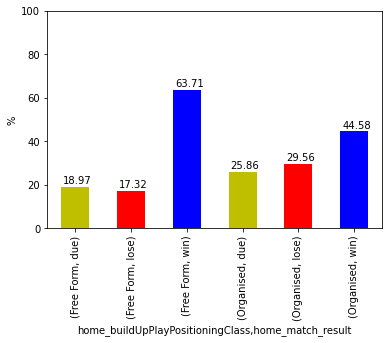

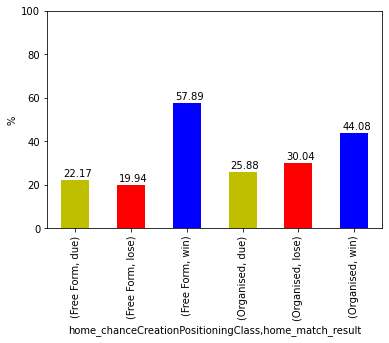

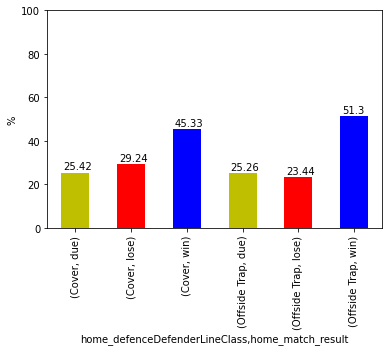

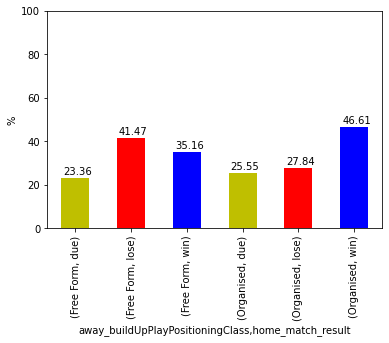

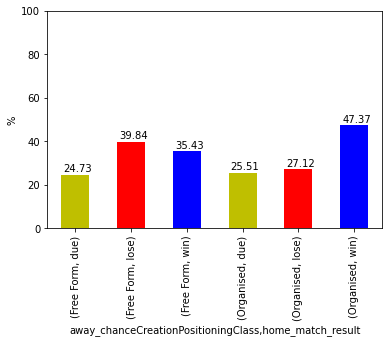

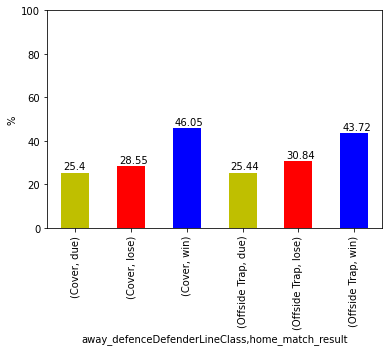

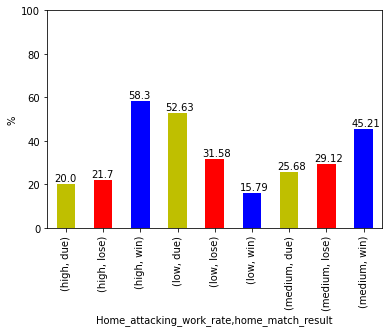

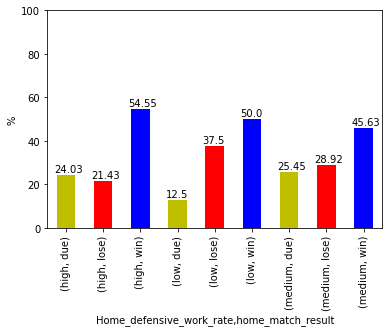

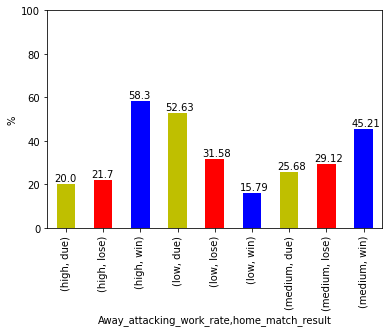

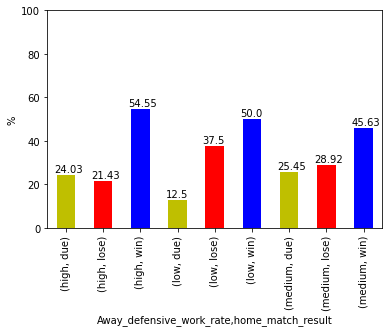

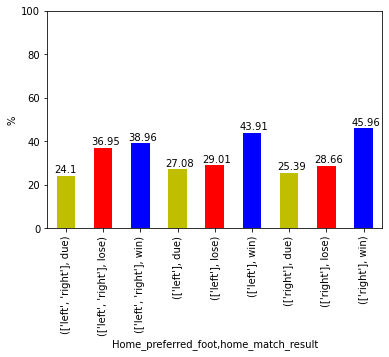

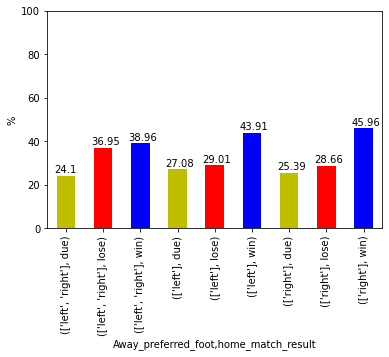

In [15]:
lst_qualitative = [
'home_buildUpPlayPositioningClass',
'home_chanceCreationPositioningClass',
'home_defenceDefenderLineClass',
'away_buildUpPlayPositioningClass',
'away_chanceCreationPositioningClass',
'away_defenceDefenderLineClass',
'Home_attacking_work_rate',
'Home_defensive_work_rate',
'Away_attacking_work_rate',
'Away_defensive_work_rate',
'Home_preferred_foot',
'Away_preferred_foot']

for i in lst_qualitative:
    zz = df_Match_update.groupby([i, 'home_match_result']).size()

    check_size2 = zz.groupby(level=i).apply(lambda x:
                                                 round(x *100/ float(x.sum()),2)).sort_index()
    fig = plt.figure()
    check_size2.plot(kind = 'bar', color = list('yrbyrbyrb')) # color lấy màu theo từng cột
    ax = fig.add_subplot(111)
    for i, v in enumerate(check_size2):
        ax.annotate(str(v), xy=(i,v), xytext=(-12,3), textcoords='offset points')

    ax.set_ylim(0.0, 100.0)
    plt.xticks(rotation=90)
    plt.ylabel('%')

- 'home_buildUpPlayPositioningClass' and 'home_chanceCreationPositioningClass' with 'Free Form' class help home team having higher win rate (corresponding 64%, 58% vs 'Organised' class 45%, 44%)  
- Oppositely, 'away_buildUpPlayPositioningClass' and 'away_chanceCreationPositioningClass' with 'Organised' class help home team having higher win rate (corresponding 47% vs 'Free Form' class 41%, 35%)
- 'home_defenceDefenderLineClass' with 'Offside Trap' class has high win rate for home team (51% vs 'Cover' class 45%) and oppositely, 'away_defenceDefenderLineClass' with 'Cover' class has high win rate (46% vs 44% 'Offside Trap' class)
- The strange thing is both 'Home_attacking_work_rate','Home_defensive_work_rate','Away_attacking_work_rate' and 'Away_defensive_work_rate' with 'High' class help  home team having higher win rate (corresponding 58% with 'attacking_work_rate' and 55% with 'defensive_work_rate', 'Home' and 'Away'same value )
- With 'right' and 'left' class, both 'Home_preferred_foot' and 'Away_preferred_foot' do affect little for the home team's win - lose - draw ratio. But with the use both of the leg and right leg at the same time, the odds of losing are highest in 'Home_preferred_foot' and 'Away_preferred_foot' attributes.

#### 4.2 Analysis team squad:

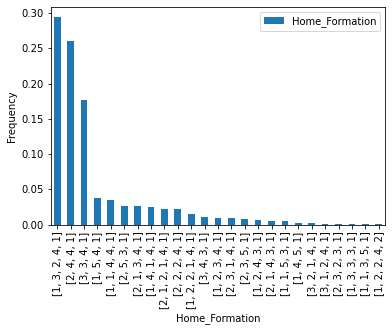

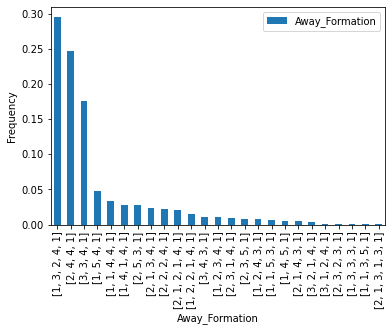

In [6]:
# Formation statistics of each team:
for i in ['Home_Formation', 'Away_Formation']:
    check_squad = df_Match_update[i].value_counts(normalize = True).reset_index()
    check_squad2 = pd.DataFrame(check_squad) 
    check_squad2.plot.bar(x='index', y= i, rot = 0)
    plt.xticks(rotation=90)  
    plt.xlabel(i)
    plt.ylabel('Frequency')

(array([0, 1, 2]),
 [Text(0, 0, '[1, 3, 2, 4, 1]'),
  Text(1, 0, '[2, 4, 4, 1]'),
  Text(2, 0, '[3, 3, 4, 1]')])

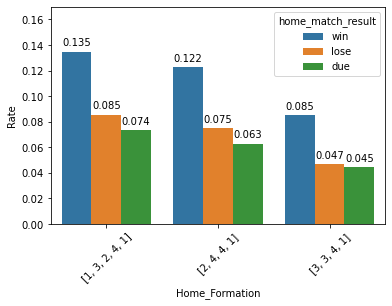

In [4]:
# Analysis home team squad:
check_squad = df_Match_update.Home_Formation.value_counts(normalize = True)
check_squad = check_squad.head(10).reset_index()
lst_squad = check_squad['index'].tolist()  # choose top 10 home team formation with highest frequency

df = df_Match_update[[ 'Home_Formation' ,'home_match_result']].value_counts(normalize=True).reset_index()
df2 = pd.DataFrame(df)
df3 = df2[df2['Home_Formation'].isin(lst_squad)]
df4 = df3.sort_values(by = ['Home_Formation', 'home_match_result'], ascending=False).reset_index()
df4 = df4.drop(['index'], axis = 1)
df4 = df4.rename({0: 'Rate'}, axis = 1)    
df5 = df4.sort_values(by = ['Rate'], ascending=False).reset_index().head(9)    
fig = plt.figure()
ax = fig.add_subplot(111)
splot = sns.barplot(y ="Rate", x="Home_Formation", hue="home_match_result", data=df5)
plt.xticks(rotation=90)  
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
ax.set_ylim(0.0,0.17)
plt.xticks(rotation=45) 

(array([0, 1, 2]),
 [Text(0, 0, '[1, 3, 2, 4, 1]'),
  Text(1, 0, '[2, 4, 4, 1]'),
  Text(2, 0, '[3, 3, 4, 1]')])

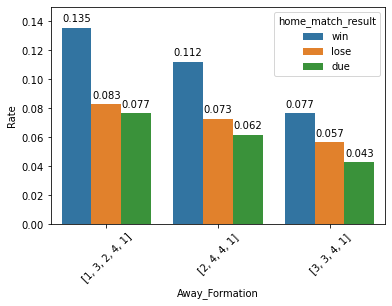

In [5]:
# Analysis away team squad:
check_squad = df_Match_update.Away_Formation.value_counts(normalize = True)
check_squad = check_squad.head(10).reset_index()
lst_squad = check_squad['index'].tolist()   # choose top 10 away team formation with highest frequency
df = df_Match_update[[ 'Away_Formation' ,'home_match_result']].value_counts(normalize=True).reset_index()
df2 = pd.DataFrame(df)
df3 = df2[df2['Away_Formation'].isin(lst_squad)]
df4 = df3.sort_values(by = ['Away_Formation', 'home_match_result'], ascending=False).reset_index()
df4 = df4.drop(['index'], axis = 1)
df4 = df4.rename({0: 'Rate'}, axis = 1)
df5 = df4.sort_values(by = ['Rate'], ascending=False).reset_index().head(9)  
fig = plt.figure()
ax = fig.add_subplot(111)
splot = sns.barplot(y ="Rate", x="Away_Formation", hue="home_match_result", data=df5)
plt.xticks(rotation=90)  
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
ax.set_ylim(0.0,0.15)
plt.xticks(rotation=45) 

- There is no significant difference in the odds of winning or losing draws between team formation if considering overall. If analyzing the details in each pair of lineup, this ratio is similar. Since the number of team formations is quite large, please see the attached Tableau analysis link attached to the end of the article to see what particular is.

#### 4.3 Analysis quantitative attributes:

In [2]:
atts = pd.read_csv('E:/ANALYST FOOTBALL/JUPITER FILE/table_Match_updateFULL_3.csv')
atts = atts.drop(atts.columns[[i for i in range(99,117)]], axis = 1)
atts = atts.drop(['Home_attacking_work_rate', 
                    'Home_defensive_work_rate',                   
                    'Away_attacking_work_rate',
                     'Away_defensive_work_rate'], axis = 1) # 92 quantitative attributes

##### 4.3.1 Analysis correlation between number of each team goals and match result:

<ipython-input-8-1d7b76b1a733>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Text(0, 0.5, '%')

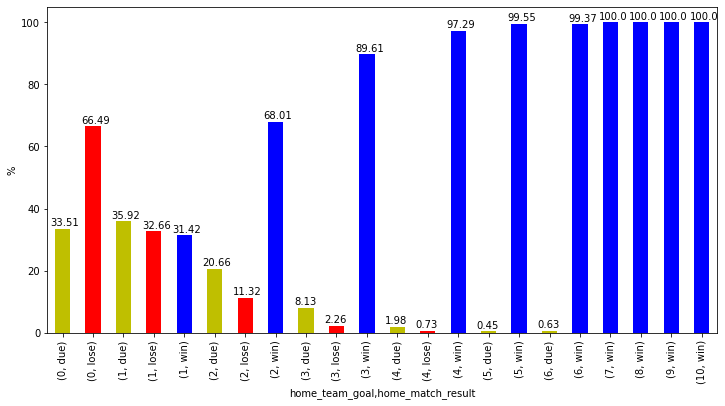

In [8]:
# Home team goals vs Home team match result:
check_goal = atts.groupby(['home_team_goal', 'home_match_result']).size()

check_size = check_goal.groupby(level='home_team_goal').apply(lambda x:
                                                 round(x *100/ float(x.sum()),2)).sort_index()

fig = plt.figure(num=None, figsize=(12, 6))
check_size.plot(kind = 'bar', color = list('yryrbyrbyrbyrbybybbbbb')) 
ax = fig.add_subplot(111)
for i, v in enumerate(check_size):
    ax.annotate(str(v), xy=(i,v), xytext=(-12,3), textcoords='offset points')

plt.xticks(rotation=90)
plt.ylabel('%')

<ipython-input-9-5e3d5274f43b>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Text(0, 0.5, '%')

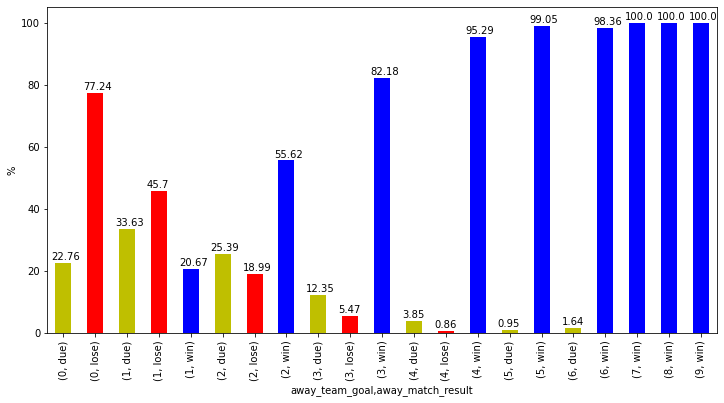

In [9]:
# Away team goals vs Away team match result:

check_goal = atts.groupby(['away_team_goal', 'away_match_result']).size()

check_size = check_goal.groupby(level='away_team_goal').apply(lambda x:
                                                 round(x *100/ float(x.sum()),2)).sort_index()

fig = plt.figure(num=None, figsize=(12, 6))
check_size.plot(kind = 'bar', color = list('yryrbyrbyrbyrbybybbbb')) 
ax = fig.add_subplot(111)
for i, v in enumerate(check_size):
    ax.annotate(str(v), xy=(i,v), xytext=(-12,3), textcoords='offset points')

plt.xticks(rotation=90)
plt.ylabel('%')

- Goal score characteristics and match results:
    + The number of goals scored by the home team of 7 or more will definitely have 100% won rate. 
    + Goals scored by the home team with a draw and loss result ranges from 0 to 6. Particularly for the number of goals is 1, the ratio of draw and loss is higher than winning.
    + The number of goals scored by the home team, if 2 or more, will have a higher winning rate (according to the number of goals +1), respectively 68%, 89%, 97.3%, 99.5%, 99.36% (lower than previous numbers but the loss rate drops to 0%) and 100%.
    + The goals scored characteristics of away team and the match result: similar to the home team with only the difference in the number of wins (from the second goal onwards, the corresponding rates increase respectively 55.62%, 82.18%, 95.29%, 99% (loss rate drops to 0%) and 100%.
- Since the attributes are all equally valued in pairs ('Home_' vs Away_' or 'home_' vs away_'), attributes are selected to analyst will be starting with 'Home_' or 'home_' and the correlation coefficient score >= 0.1

##### 4.3.2 Analysis correlation between number of each team goals and other attributes:

In [3]:
corr = atts.corr().unstack()[['home_team_goal']].reset_index().sort_values(by = 0, ascending = False)
print(corr.head(60))

           level_0                      level_1         0
2   home_team_goal               home_team_goal  1.000000
4   home_team_goal                   home_point  0.624226
33  home_team_goal               Home_dribbling  0.186215
68  home_team_goal               Away_dribbling  0.186215
69  home_team_goal                   Away_curve  0.180025
34  home_team_goal                   Home_curve  0.180025
64  home_team_goal               Away_finishing  0.179663
29  home_team_goal               Home_finishing  0.179663
27  home_team_goal               Home_potential  0.177380
62  home_team_goal               Away_potential  0.177380
31  home_team_goal           Home_short_passing  0.176364
66  home_team_goal           Away_short_passing  0.176364
51  home_team_goal                  Home_vision  0.175785
67  home_team_goal                 Away_volleys  0.174635
32  home_team_goal                 Home_volleys  0.174635
72  home_team_goal            Away_ball_control  0.174479
37  home_team_

=> Attributes with a correlation coefficient value >= 0.1 are all attributes belonging to players ('Home_'), not attributes of  teams ('home_')

- If analysis is based on the home match result ('home_point'), it will be difficult to see the difference in attribute characteristics. The following analysis will analyze attributes based on the number of goals scored by team.

<ipython-input-3-3b7268cabbc6>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


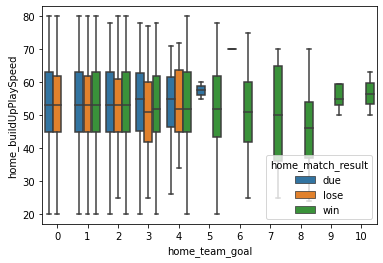

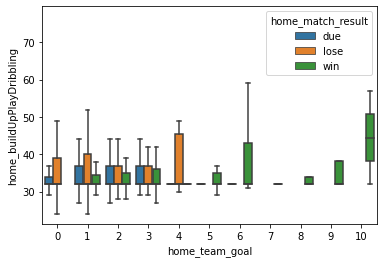

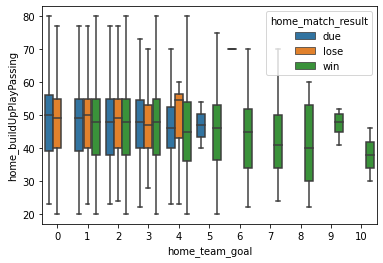

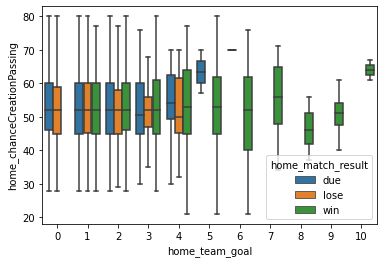

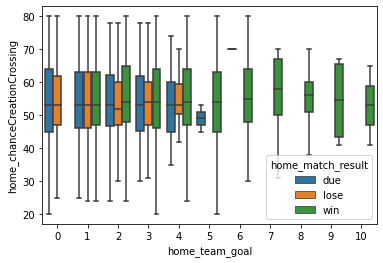

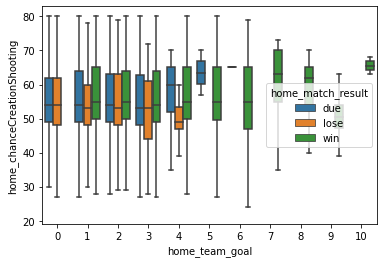

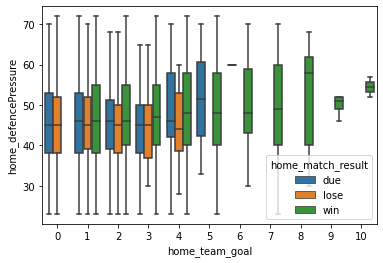

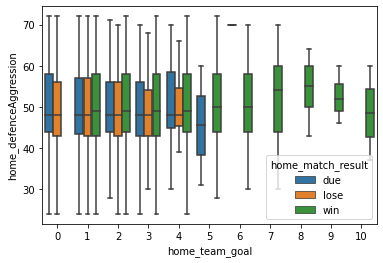

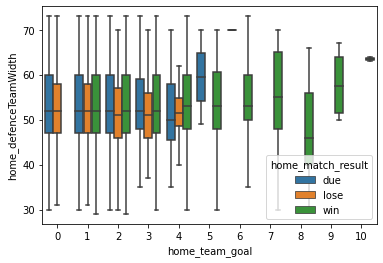

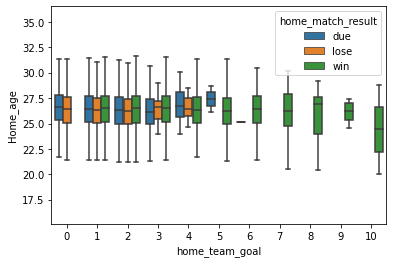

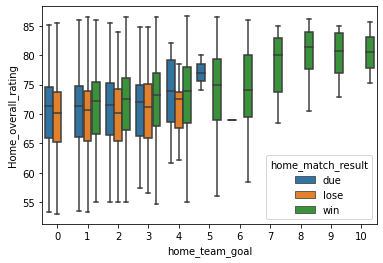

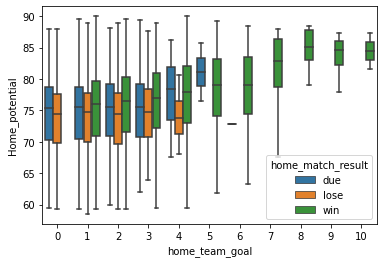

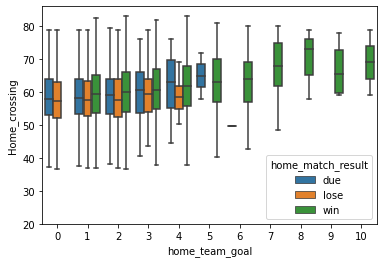

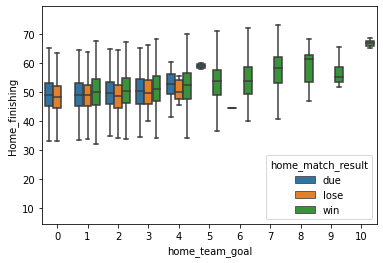

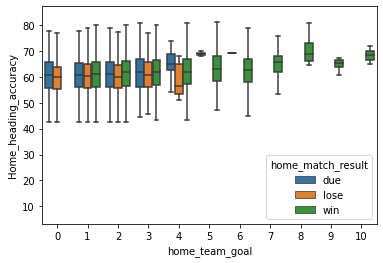

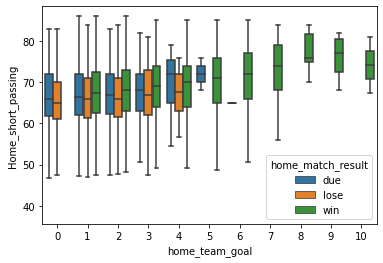

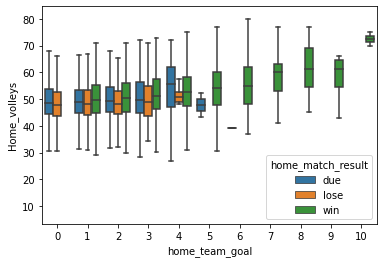

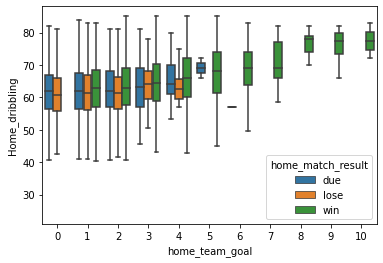

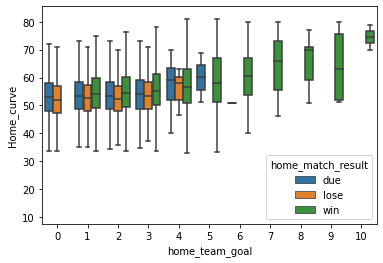

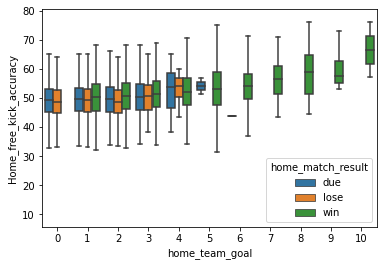

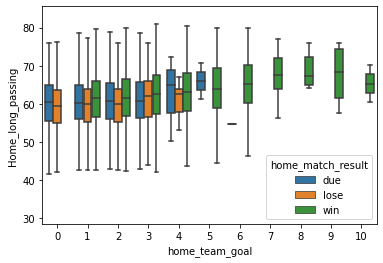

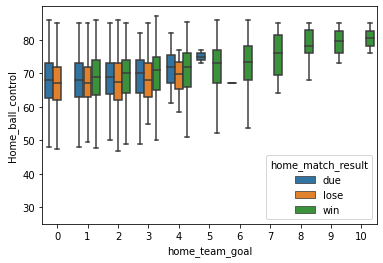

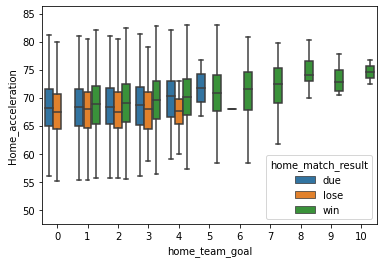

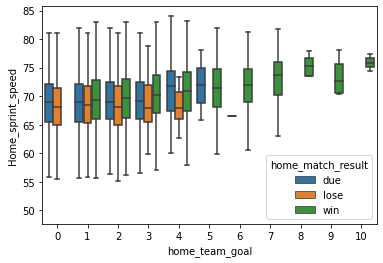

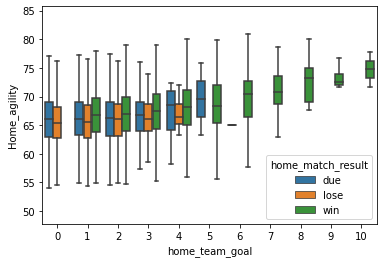

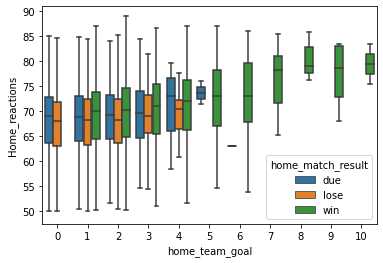

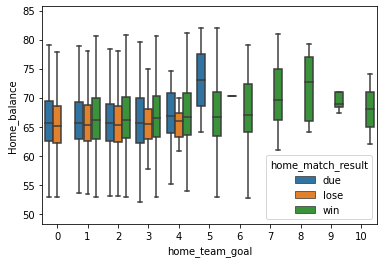

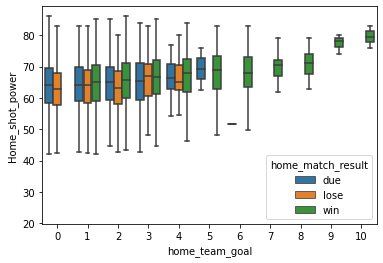

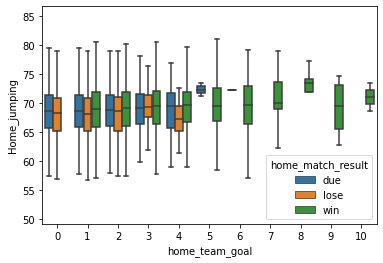

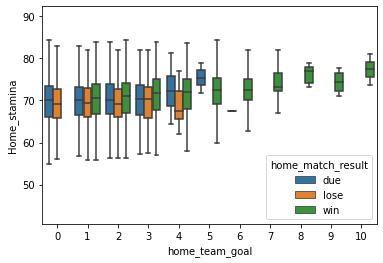

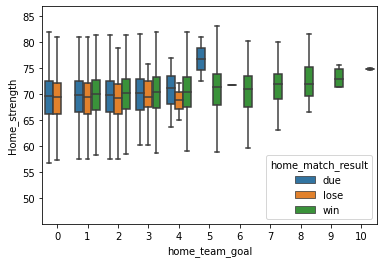

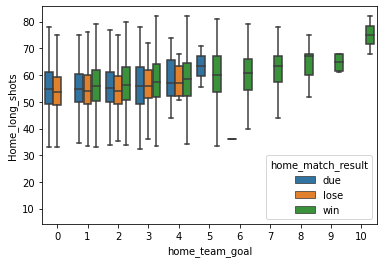

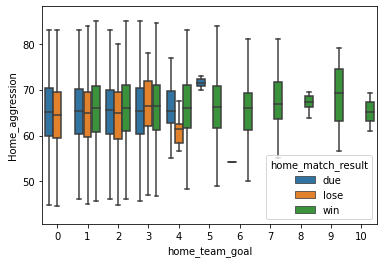

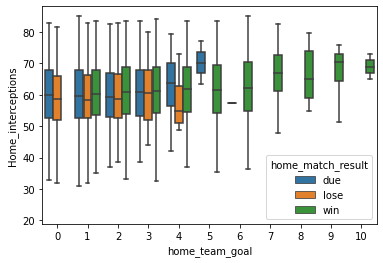

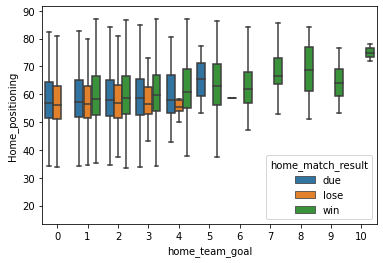

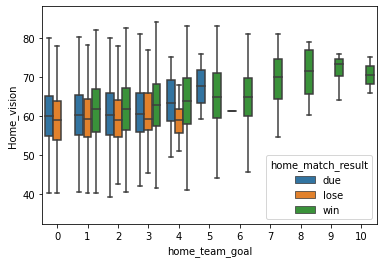

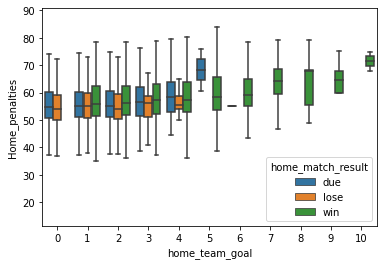

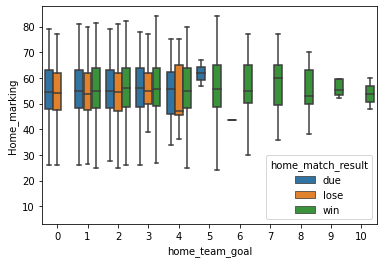

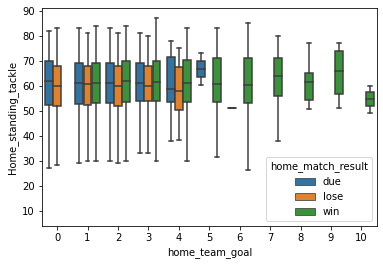

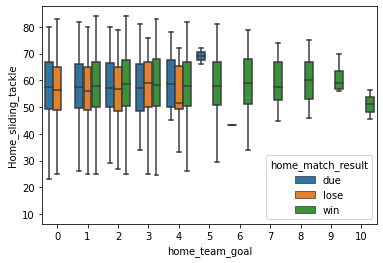

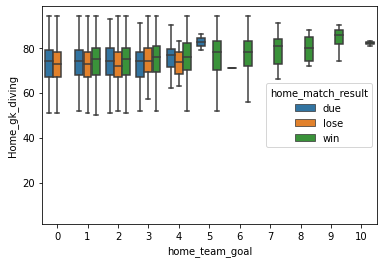

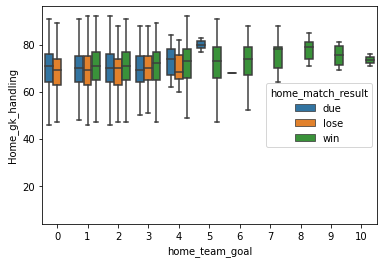

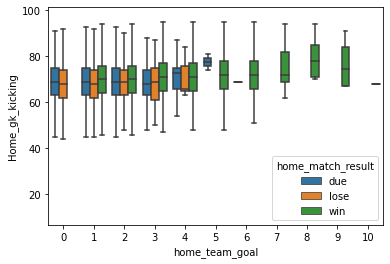

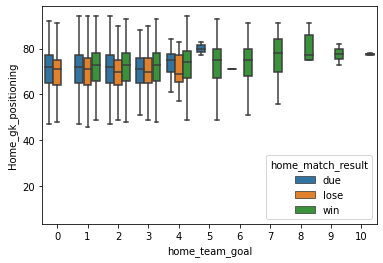

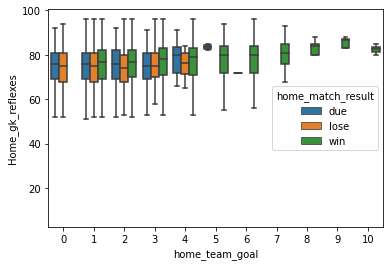

<Figure size 432x288 with 0 Axes>

In [3]:
cols = list(atts.columns)
lst_home = []
for i in cols:
    if i.startswith('Home') or i.startswith('home'):
        lst_home.append(i)
lst_home2 = [e for e in lst_home if e not in ('home_team_goal', 'away_team_goal', 'home_match_result', 'home_point', 'away_point')]
for i in lst_home2:
    sns.boxplot(x="home_team_goal", y = i, hue = 'home_match_result', data=atts, fliersize=0)
    plt.figure()  

#### Based on the above Boxplot graphs:
- Except for Home_Team_Goal and Away_Team_Goal, there is a clear distribution of goals and result match of teams. The distribution of the match results (win - lose - draw) between the remaining attributes is not clear (there is a lot of noise between these attributes).
- The following analysis will consider the relationship between the home team's goals and the team's stats:
    +  Attributes with narrowing amplitude increase with increasing number of goals including: 'Home_overall_rating', 'Home_potential', 'Home_crossing', 'Home_finishing', 'Home_heading_accuracy', 'Home_short_passing','Home_volleys', 'Home_dribbling', 'Home_curve', 'Home_free_kick_accuracy', 'Home_long_passing', 'Home_ball_control', 'Home_acceleration', 'Home_sprint_speed', 'Home_agility', 'Home_reactions', 'Home_balance', 'Home_shot_power','Home_jumping', 'Home_stamina', 'Home_strength', 'Home_long_shots', 'Home_aggression', 'Home_interceptions', 'Home_positioning', 'Home_vision', 'Home_penalties', 'Home_marking','Home_standing_tackle', 'Home_sliding_tackle', 'Home_gk_diving', 'Home_gk_handling', 'Home_gk_kicking', 'Home_gk_positioning','Home_gk_reflexes'(35 attributes)
    +  It is worth noting that the degree of goal score narrowing of attribute points tends to lie in the middle, rather than moving up in the normal sense, the more goals you score, the higher the attribute index must be. and vice versa. The attributes with such characteristics include: 'home_buildUpPlaySpeed', 'home_chanceCreationCrossing', 'home_buildUpPlayDribbling', 'home_chanceCreationShooting', 'home_defenceTeamWidth', 'home_defencePressure', 'home_defenceAggression'. (7 attributes)
    + The remaining attributes have narrowing amplitudes with the number of home goals: 'home_buildUpPlayPassing', 'home_chanceCreationPassing', 'Home_age'. (3 attributes)

### 5. Use  Logistic Regression (LR) and Random Forest Classification (RFC)  to predict home match result:

In [5]:
# Case 1: Use all attributes
atts = pd.read_csv('path/file.csv')
atts2 = atts.drop(['home_point', 'away_point', 'home_match_result'], axis = 1)
X = atts2.values
y= atts['home_point'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)
# LR
logres = LogisticRegression()
logres.fit(X_train, y_train)
y_pred = logres.predict(X_test)
print('----Logistic Regression----')
print('LR model accuracy: ', metrics.accuracy_score(y_test, y_pred)* 100,'%') 
print('----Evaluating the LR Algorithm----')
print('Mean Absolute Error of LR model:', metrics.mean_absolute_error(y_test, y_pred)* 100, '%')
print('Mean Squared Error of LR model:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error of LR model:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

print('\n')
print('----Random Forest Classification----')
# RFC
clf=RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('RFC model accuracy: ',metrics.accuracy_score(y_test, y_pred) * 100,"%") 
print('----Evaluating the RFC Algorithm----')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) * 100, '%')
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

C:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----Logistic Regression----
LR model accuracy:  68.65700861393891 %
----Evaluating the LR Algorithm----
Mean Absolute Error of LR model: 35.512920908379016 %
Mean Squared Error of LR model: 43.85277995301488 %
Root Mean Squared Error of LR model: 6.622143154071413 %


----Random Forest Classification----
RFC model accuracy:  97.5724353954581 %
----Evaluating the RFC Algorithm----
Mean Absolute Error: 2.682067345340642 %
Mean Squared Error: 3.1910728269381363 %
Root Mean Squared Error: 1.7863574185862516 %


In [6]:
# Case 2: Use all attributes except match goal score:
atts = pd.read_csv('path.csv')
atts2 = atts.drop(['home_match_result', 'home_point', 'away_point', 'home_team_goal', 'away_team_goal'], axis =1)
X = atts2.values
y= atts['home_point'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)
# LR
logres = LogisticRegression()
logres.fit(X_train, y_train)
y_pred = logres.predict(X_test)
print('----Logistic Regression----')
print('LR model accuracy: ', metrics.accuracy_score(y_test, y_pred)* 100,'%') 
print('----Evaluating the LR Algorithm----')
print('Mean Absolute Error of LR model:', metrics.mean_absolute_error(y_test, y_pred)* 100, '%')
print('Mean Squared Error of LR model:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error of LR model:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

print('\n')
print('----Random Forest Classification----')
# RFC
clf=RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('RFC model accuracy: ',metrics.accuracy_score(y_test, y_pred) * 100,"%") 
print('----Evaluating the RFC Algorithm----')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) * 100, '%')
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

C:\Users\ADMIN\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----Logistic Regression----
LR model accuracy:  47.31793265465936 %
----Evaluating the LR Algorithm----
Mean Absolute Error of LR model: 79.796397807361 %
Mean Squared Error of LR model: 134.0250587314017 %
Root Mean Squared Error of LR model: 11.576919224534725 %


----Random Forest Classification----
RFC model accuracy:  47.31793265465936 %
----Evaluating the RFC Algorithm----
Mean Absolute Error: 77.19263899765075 %
Mean Squared Error: 126.21378230227094 %
Root Mean Squared Error: 11.23449074512374 %


##### If the total of two teams scored in a match's 0, it's difficult for algorithms to distinguish the winner and loser or even. To increase model accuracy, the data will be adjusted to total more goals than 1.

In [6]:
# Case 3: Adjust 2 team goals:
atts = pd.read_csv('path.csv')
def get_total(row):
    temp = row['home_team_goal'] + row['away_team_goal']
    return temp
atts['total_goals'] = atts.apply(get_total, axis = 1)


In [32]:
# Using 2 team goals:
atts = atts[atts.total_goals >= 1]
atts2 = atts.drop(['home_point', 'away_point', 'home_match_result'], axis = 1)
X = atts2.values
y= atts['home_point'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)
# LR
logres = LogisticRegression()
logres.fit(X_train, y_train)
y_pred = logres.predict(X_test)
print('----Logistic Regression----')
print('LR model accuracy: ', metrics.accuracy_score(y_test, y_pred)* 100,'%') 
print('----Evaluating the LR Algorithm----')
print('Mean Absolute Error of LR model:', metrics.mean_absolute_error(y_test, y_pred)* 100, '%')
print('Mean Squared Error of LR model:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error of LR model:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

print('\n')
print('----Random Forest Classification----')
# RFC
clf=RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('RFC model accuracy: ',metrics.accuracy_score(y_test, y_pred) * 100,"%") 
print('----Evaluating the RFC Algorithm----')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) * 100, '%')
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

C:\Users\aston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----Logistic Regression----
LR model accuracy:  72.39807546214232 %
----Evaluating the LR Algorithm----
Mean Absolute Error of LR model: 31.324385920486197 %
Mean Squared Error of LR model: 38.769308685743226 %
Root Mean Squared Error of LR model: 6.226500516802615 %


----Random Forest Classification----
RFC model accuracy:  98.91111673841479 %
----Evaluating the RFC Algorithm----
Mean Absolute Error: 1.316789060521651 %
Mean Squared Error: 1.7726006583945304 %
Root Mean Squared Error: 1.3313904980863167 %


In [7]:
# Not using 2 team goals:
atts = atts[atts.total_goals >= 1]
atts2 = atts.drop(['home_point', 'away_point', 'home_match_result', 'home_team_goal', 'away_team_goal'], axis = 1)
X = atts2.values
y= atts['home_point'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)
# LR
logres = LogisticRegression()
logres.fit(X_train, y_train)
y_pred = logres.predict(X_test)
print('----Logistic Regression----')
print('LR model accuracy: ', metrics.accuracy_score(y_test, y_pred)* 100,'%') 
print('----Evaluating the LR Algorithm----')
print('Mean Absolute Error of LR model:', metrics.mean_absolute_error(y_test, y_pred)* 100, '%')
print('Mean Squared Error of LR model:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error of LR model:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')

print('\n')
print('----Random Forest Classification----')
# RFC
clf=RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('RFC model accuracy: ',metrics.accuracy_score(y_test, y_pred) * 100,"%") 
print('----Evaluating the RFC Algorithm----')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) * 100, '%')
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)* 100, '%')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100), '%')
    

C:\Users\aston\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----Logistic Regression----
LR model accuracy:  50.529661016949156 %
----Evaluating the LR Algorithm----
Mean Absolute Error of LR model: 80.1906779661017 %
Mean Squared Error of LR model: 141.6313559322034 %
Root Mean Squared Error of LR model: 11.900897274247997 %


----Random Forest Classification----
RFC model accuracy:  52.64830508474576 %
----Evaluating the RFC Algorithm----
Mean Absolute Error: 75.59322033898304 %
Mean Squared Error: 132.07627118644066 %
Root Mean Squared Error: 11.492444091073084 %


### Conclusion:
- Except for the team's formation and team goals , all input attributes do not have any attribute with a remarkable influence on the match result. Attributes from the player have a higher influence than common attributes from team.
- Important attributes of player if considered independent will be followed: 'dribbling', 'curve', 'finishing', 'potential', 'passing', 'vision', 'volleys', 'ball_control', 'overall_rating', 'reactions', 'agility', 'free_kick_accuracy', 'long_passing', 'crossing', 'long_shots', 'acceleration', 'shot_power', 'sprint_speed', 'positioning', 'penalties', 'stamina', 'balance', 'heading_accuracy', 'jumping', 'interceptions', 'strength', 'aggression','kicking - positioning - handling - reflexes - diving'(Goal keeper), 'sliding_tackle', 'marking', 'standing_tackle' (total of 35 skills with higher stats the better)
- About using machine learning for prediction, if only based on the attributes of the player and team, the LR and RFC accuracy's only 50- 52%. But if there is history of the match scores adding then the accuracy are 72.4% (LR) and 98.91% (RFC).

#####  The chart clearly shows these analytical sections and other statistics, please visit the following website:
https://public.tableau.com/views/FOOTBALL_ANALYST_FINAL/Analyzethefactorsthataffectmatchresult?:language=en&:display_count=y&:origin=viz_share_link